### 1. Develop a classification model which predicts which LOL team will win using the data available at https://www.kaggle.com/datasnaek/league-of-legends. Walk us through why you picked the model you did and what your results are. Be specific on how you chose to evaluate your model.



In [159]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

games_raw = pd.read_csv('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/games.csv')

In [160]:
games_raw.head(10)

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
5,3287435705,1501667992132,2059,9,1,2,2,1,1,2,...,6,0,0,3,0,119,134,154,63,31
6,3314215542,1503430065724,1993,9,1,1,2,1,1,1,...,2,0,0,0,0,75,42,31,40,429
7,3329224025,1504472363684,1334,9,1,1,1,0,0,2,...,0,0,0,2,0,157,38,122,40,238
8,3318040883,1503686577549,1387,9,2,2,2,2,0,2,...,8,1,0,2,1,28,51,53,157,40
9,3327786881,1504385918871,2681,9,2,2,2,2,2,2,...,8,3,1,2,0,64,141,84,67,53


In [161]:
games_raw.info() # no null-values, all variables are int64, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gameId              51490 non-null  int64
 1   creationTime        51490 non-null  int64
 2   gameDuration        51490 non-null  int64
 3   seasonId            51490 non-null  int64
 4   winner              51490 non-null  int64
 5   firstBlood          51490 non-null  int64
 6   firstTower          51490 non-null  int64
 7   firstInhibitor      51490 non-null  int64
 8   firstBaron          51490 non-null  int64
 9   firstDragon         51490 non-null  int64
 10  firstRiftHerald     51490 non-null  int64
 11  t1_champ1id         51490 non-null  int64
 12  t1_champ1_sum1      51490 non-null  int64
 13  t1_champ1_sum2      51490 non-null  int64
 14  t1_champ2id         51490 non-null  int64
 15  t1_champ2_sum1      51490 non-null  int64
 16  t1_champ2_sum2      51490 non-null  int6

In [162]:
print('Duplicate rows in the raw data: ', games_raw.duplicated().any(axis=0))
#ids = games['gameId'] # run to view duplicates
#games[ids.isin(ids[ids.duplicated()])].sort_values('gameId')

# drop duplicate values
games_temp = games_raw.drop_duplicates()

Duplicate rows in the raw data:  True


In [163]:
games_temp.groupby(['seasonId'])['seasonId'].count() # seasonId same for all games

seasonId
9    51053
Name: seasonId, dtype: int64

In [164]:
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/champion_info.json')
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/champion_info_2.json')
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/summoner_spell_info.json')

### Notes on what data we will proceed with:



Notes on dropped variables:
- gameId: no predictive power
- creationTime: no predictive power unless we want to care for chronological ordering such as with bayesian models
- seasonId: all games are from the same season
- selection of champions and bans: there is likely signal in the choice of champions, but that comes at the cost of one hot encoding. One could do this by type of champion rather than by champion id, we all know that games with 5 carrys usually dont end up well.
- gameDuration: By itself this variable is not of any use. However, combined with champion selection by type/role it might have a synergistic effect that provides predictive power.

In [165]:
games_temp_2 = games_temp[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron' ,'firstDragon', 'firstRiftHerald'
                   ,'t1_towerKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills'
                   ,'t2_towerKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
games_temp_2

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1,2,1,1,1,1,2,11,2,3,0,5,0,1,1
1,1,1,1,1,0,1,1,10,0,2,1,2,0,0,0
2,1,2,1,1,1,2,0,8,1,1,0,2,0,1,0
3,1,1,1,1,1,1,0,9,1,2,0,0,0,0,0
4,1,2,1,1,1,1,0,9,1,3,0,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,2,1,2,2,0,2,0,2,0,0,0,10,0,4,0
51486,2,1,1,2,2,2,2,5,0,2,0,11,4,4,1
51487,2,2,2,2,0,1,0,0,0,1,0,10,0,2,0
51488,2,2,2,2,0,2,0,0,0,0,0,11,0,1,0


In [209]:
firstBlood = pd.get_dummies(games_temp_2['firstBlood'], prefix='firstBlood', drop_first = False)
firstTower = pd.get_dummies(games_temp_2['firstTower'], prefix='firstTower', drop_first = False)
firstInhibitor = pd.get_dummies(games_temp_2['firstInhibitor'], prefix='firstInhibitor', drop_first = True)
firstBaron = pd.get_dummies(games_temp_2['firstBaron'], prefix='firstBaron', drop_first = True)
firstDragon = pd.get_dummies(games_temp_2['firstDragon'], prefix='firstDragon', drop_first = True)
firstRiftHerald = pd.get_dummies(games_temp_2['firstRiftHerald'], prefix='firstRiftHerald', drop_first = True)

# Combine the one hot encoded columns with df_con_enc
games_conc = pd.concat([games_temp_2, firstBlood, firstTower, firstInhibitor, firstBaron, firstDragon, firstRiftHerald], axis=1)

# drop original columns that were onehot encoded
games = games_conc.drop(['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald'], axis='columns')

Correlations against the winner variable: 
 t1_towerKills        -0.771571
firstInhibitor_1     -0.724602
t1_dragonKills       -0.472635
firstTower_1         -0.406367
firstBaron_1         -0.387115
t1_baronKills        -0.369883
firstDragon_1        -0.344566
t1_riftHeraldKills   -0.218057
firstRiftHerald_1    -0.218057
firstBlood_1         -0.180038
firstBlood_0         -0.006585
firstTower_0         -0.003794
firstBlood_2          0.181500
firstRiftHerald_2     0.226131
t2_riftHeraldKills    0.226131
firstDragon_2         0.349054
t2_baronKills         0.398692
firstTower_2          0.408051
firstBaron_2          0.423358
t2_dragonKills        0.497055
firstInhibitor_2      0.730113
t2_towerKills         0.785722
winner                1.000000
Name: winner, dtype: float64


<AxesSubplot: >

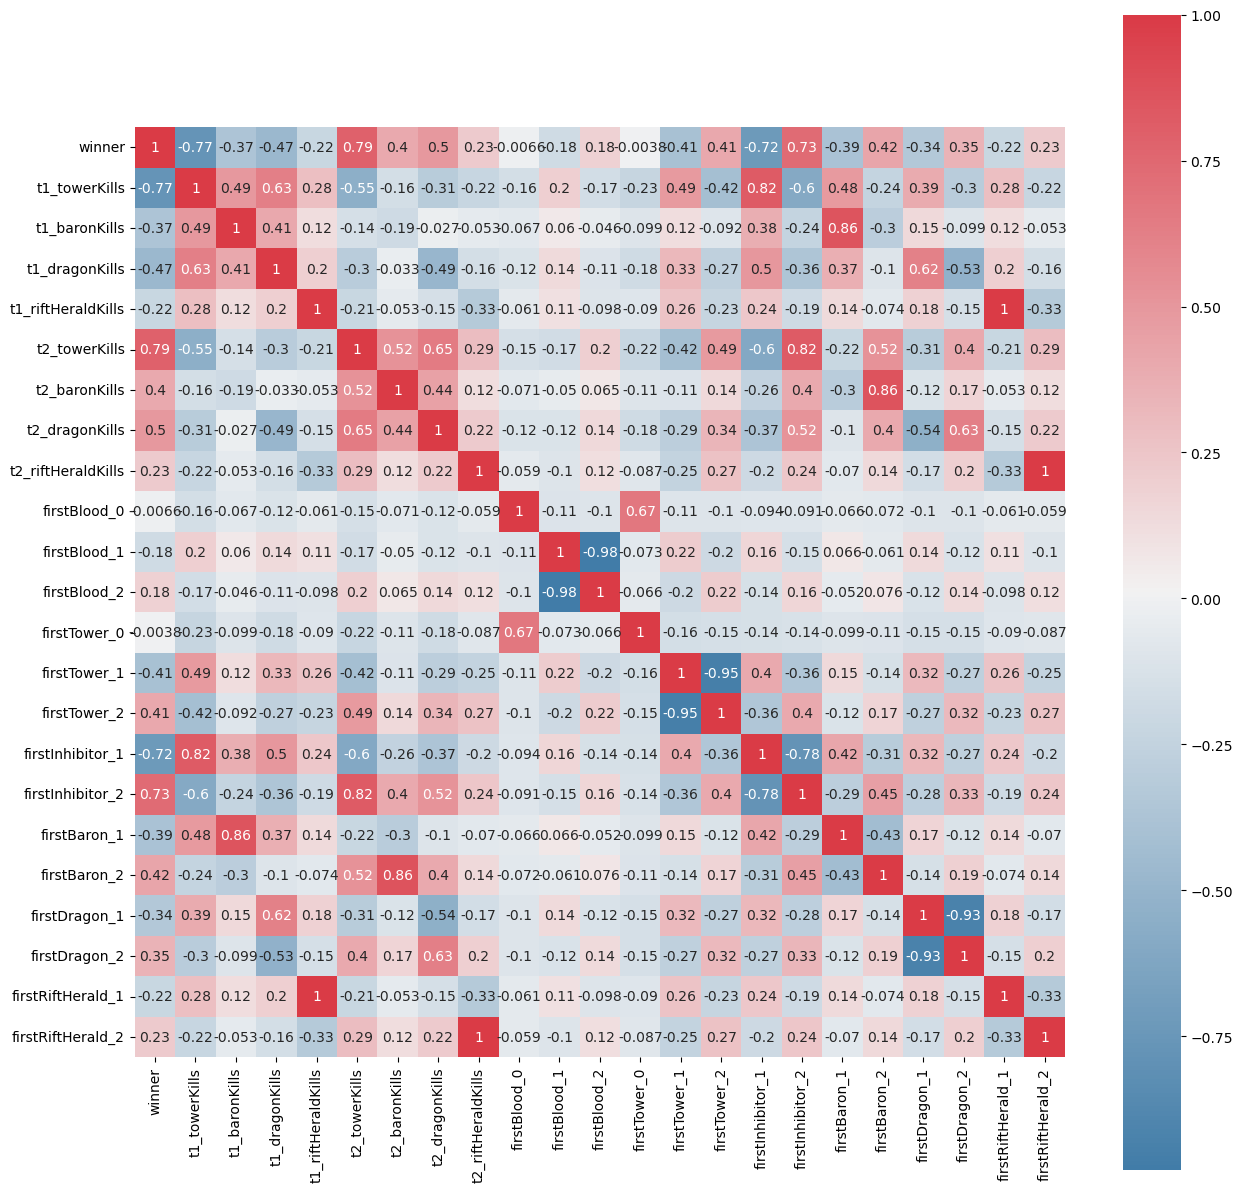

In [210]:
f, ax = pl.subplots(figsize=(15, 15))
print('Correlations against the winner variable: \n' , games.corr()['winner'].sort_values())
corr = games.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True), square=True, annot=True, ax=ax)

# Splitting data into train and test (and validation?)

In [213]:
matches = games

X = matches.drop(['winner', 
                  'firstBaron_1', 'firstBaron_2', 
                  'firstDragon_1', 'firstDragon_2', 
                  'firstRiftHerald_1', 'firstRiftHerald_2',
                 'firstBlood_1', 'firstTower_1'], axis='columns')
y = matches['winner']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

lr = LogisticRegression()
lr.fit(X_train, Y_train)

predictions = lr.predict(X_test)

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           1       0.96      0.96      0.96      7760
           2       0.96      0.96      0.96      7556

    accuracy                           0.96     15316
   macro avg       0.96      0.96      0.96     15316
weighted avg       0.96      0.96      0.96     15316



### 2. From a classification standpoint we (often) assume a decision-rule “if 𝑝 > 0.5 classify as A otherwise B”. Such a decision rule may be good for classification but in the context of odds we are more interested in the uncertainty of the prediction 𝑝 and if the prediction is close to the true quantity 𝑝. Discuss if your model would be applicable in this setting. Would you evaluate your model differently if your aim is to compare the prediction 𝑝 and the true ? Can you perform such a comparison? Obs. 𝑝 this question is essentially open-ended and will be discussed further in person!

- true quantity can not be known, hence we can not know if our prediction is close to the true quantity in terms of a distance between $d(\hat{p},p)$
- we can however evaluate how well the model predicts the winner (we actually have data on that!)
- any smart work arounds? what is even meant by true p? a true underlying probability that a team will win... such can not be known, only modeled

### 3. If you were to have more time, what would you like to add to the project?
